<a href="https://colab.research.google.com/github/arya0607/ML-in-Practice/blob/main/Copy_of_10718_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10718 Assignment 1: Getting to know the class project

## Overview

The purpose of this exercise is to provide a quick introduction to the data and modeling problem we'll be using as an illustrative example throughout Machine Learning in Practice (10-718). Note that this colab notebook **only uses a small sample of the data**, but we'll be working with the full dataset as you get into your group projects for the rest of the semester.

**Completing this assignment should only take you 2-3 hours.**

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers).

Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, let's assume that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has ** time to review and support only 10% of the projects posted to the platform on a given day**.

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to **identify projects that are least likely to be fully funded before they expire**  and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [1]:
print("hello world")

hello world


In [2]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main
W: http://apt.postgresql.org/pub/repos/apt/dists/jammy-pgdg/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 12.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libjson-perl.
(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack .../00-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package netbase.
Preparing to un

In [3]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [5]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [7]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [8]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

** Note that if you prefer to work in python to explore and manipulate the data, you can download a full table (for example, `data.projects`) into a pandas dataframe via**:
```
projects_df = pd.read_sql("SELECT * FROM data.projects", db_engine)
```

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

In [79]:
def q(s):
  display(pd.read_sql(s, db_engine))
q('SELECT * FROM data.projects')

,schoolid,projectid_str,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,entity_id
0,29a2da790e38b6c8a1c70aced6b9c765,30c034618e67d00c641f9b5b7775c0f4,0903da60e148adc6280d55f5d94791a5,192013001182,41.428391,-91.049135,Muscatine,IA,52761,None,Muscatine Cmty School District,Muscatine,False,False,False,False,False,False,Ms.,False,False,Applied Sciences,Math & Science,College & Career Prep,Applied Learning,Supplies,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False,2012-08-06,234148
1,06ef48acbdf9b013d4bc4bfc8d328cc1,94199c544d9d2926c1820e5c6cde1eb6,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,ESL,Literacy & Language,Supplies,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False,2010-07-10,453579
2,06ef48acbdf9b013d4bc4bfc8d328cc1,61f42f174afef1ed2419ab948a647137,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,Applied Sciences,Math & Science,Other,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False,2011-06-09,353855
3,06ef48acbdf9b013d4bc4bfc8d328cc1,c966f5226f42aaaf6b115d7dbaefdea3,e0b5a72f41a376b28db9c2e838a24de5,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,Health & Life Science,Math & Science,Other,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False,2011-06-13,353178
4,06ef48acbdf9b013d4bc4bfc8d328cc1,69e9c24111daa1e6ba64c6d5538e4df1,32e86c49396707f71fdc0398ab2b844b,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,History & Geography,History & Civics,Environmental Science,Math & Science,Books,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False,2012-07-15,239363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,dde161252564ad07a75b072f0f90705f,b9377e2c5734e5305ef8c30da68d7f11,2d6b1be90d7b259f8f59f2a2eee58c31,120039000435,25.835409,-80.215416,Miami,FL,33150,None,Miami-dade Co Public Sch Dist,Miami-Dade,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,None,None,Technology,highest poverty,Grades 3-5,30.0,568.28,668.56,250,True,False,2013-10-28,72582
16476,dde161252564ad07a75b072f0f90705f,5a6ffc36770a51713c7e064fbc71d39e,6ce23352bdbf0339316f7a1341499644,120039000435,25.835409,-80.215416,Miami,FL,33150,None,Miami-dade Co Public Sch Dist,Miami-Dade,False,False,False,False,False,False,Ms.,True,False,Literature & Writing,Literacy & Language,Literacy,Literacy & Language,Books,highest poverty,Grades 3-5,30.0,701.99,825.87,100,True,False,2013-10-28,72531
16477,dde161252564ad07a75b072f0f90705f,311bf0bc005e4de4a89cac20d858262b,caeefdb8e667c31af8b79f08b4a3d26b,120039000435,25.835409,-80.215416,Miami,FL,33150,None,Miami-dade Co Public Sch Dist,Miami-Dade,False,False,False,False,False,False,Ms.,True,False,Mathematics,Math & Science,Literature & Writing,Literacy & Language,Technology,highest poverty,Grades PreK-2,30.0,1440.59,1694.81,17,False,False,2013-11-23,57416
16478,dde161252564ad

# QUESTION 1

**(A)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

,id,sum,sum,sum,donated_ratio,total_item
0,0423c18927379ee4091d11aabfb12ef3,3535.52,3075.92,384.49,0.125000,8.0
1,181b32a7a1ce28950c8ef9941a9f6245,8651.52,7353.72,2451.24,0.333333,18.0
2,1a3aaeffc56dd2a421e37d8298024c0a,2012.40,1710.54,153.00,0.089445,8.0
3,2802507fd30a5839f672174e8685d10f,1662.25,1363.05,57.40,0.042111,110.0
4,2845815efe9e21b49c088ac0556b57c6,337.66,276.88,36.90,0.133271,10.0
5,472bc074672ffc4021c8b4d8ba5d5a5f,3558.00,2917.56,243.13,0.083333,24.0
6,4ea2875bd43ebc8a2cd74bfdaa3aa11d,734.08,623.96,31.25,0.050083,2.0
7,5870c45161349bdbc0def1a5631d43ce,5557.50,4723.94,2361.97,0.500000,36.0
8,5c16a1a98221b16621d873c9261e593d,5949.60,4878.72,1219.68,0.250000,184.0
9,627d3158c2e899318c7e9b6722eaff8f,1770.72,1452.00,484.00,0.333333,6.0


<Axes: title={'center': 'the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire'}, xlabel='total_item', ylabel='donated_ratio'>

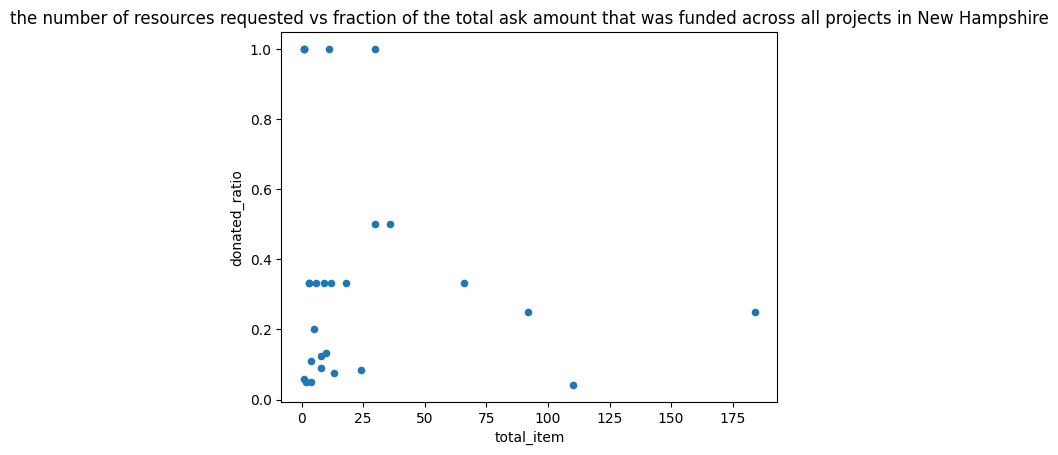

In [90]:
# q("SELECT r.projectid_str, SUM(item_quantity), d.donation_to_project, d.donation_total \
# FROM data.projects AS p \
# INNER JOIN data.donations AS d ON p.projectid_str = d.projectid_str \
# INNER JOIN data.resources AS r ON p.projectid_str = r.projectid_str \
# WHERE p.school_state = 'NH' \
# GROUP BY r.projectid_str; \
# ")

# q("SELECT r.projectid_str, SUM(item_quantity), d.donation_to_project, d.donation_total \
# FROM data.donations AS d \
# INNER JOIN data.resources AS r ON d.projectid_str = r.projectid_str \
# WHERE d.school_state = 'NH' \
# GROUP BY r.projectid_str; \
# ")

# q("SELECT p.projectid_str AS id, SUM(d.donation_total) AS donated, SUM(p.total_price_including_optional_support) AS price, SUM(r.item_quantity) \
# FROM data.donations AS d \
# INNER JOIN data.projects AS p \
# ON d.projectid_str = p.projectid_str \
# GROUP BY p.projectid_str \
# INNER JOIN data.resources AS r \
# ON p.projectid_str = r.projectid_str \
# GROUP BY r.projectid_str \
# ")
s = "SELECT p.projectid_str AS id, \
SUM(p.total_price_including_optional_support), \
SUM(p.total_asking_price), \
SUM(d.donation_to_project), \
SUM(d.donation_to_project)  / SUM(p.total_asking_price) AS donated_ratio,  \
SUM(r.item_quantity) AS total_item \
FROM data.donations AS d \
INNER JOIN data.projects AS p ON d.projectid_str = p.projectid_str \
INNER JOIN data.resources AS r ON p.projectid_str = r.projectid_str \
WHERE p.school_state = 'NH' \
GROUP BY p.projectid_str \
"

t = "SELECT p.projectid_str AS id, \
SUM(d.donation_to_project)  / SUM(p.total_asking_price) AS donated_ratio,  \
SUM(r.item_quantity) AS total_item \
FROM data.donations AS d \
INNER JOIN data.projects AS p ON d.projectid_str = p.projectid_str \
INNER JOIN data.resources AS r ON p.projectid_str = r.projectid_str \
WHERE p.school_state = 'NH' \
GROUP BY p.projectid_str \
"
q(s)
pd.read_sql(t, db_engine).plot.scatter(x='total_item', y='donated_ratio',title='\
the number of resources requested vs fraction of the total ask amount that was \
funded across all projects in New Hampshire')



**(B)** Spend a little time exploring the data, with a focus on the outcome of whether or not a project is fully funded after 4 months as well as features you think might be predictive of this outcome.

,id,donated_ratio,asking,charter,magnet,met
0,0000fa3aa8f6649abab23615b546016d,0.166667,1440.60,0,0,0.0
1,0006a31d45f8d52d217e7c5b55c11f37,1.000000,712.94,0,0,1.0
2,000bf12405c7af331dfaf0af72ca179d,0.125000,2003.36,0,0,0.0
3,000faa31e276e9e649360949207fa00c,1.000000,537.31,0,0,1.0
4,00137dafd108d72b0752afad2728427f,0.111111,3035.70,0,0,0.0
...,...,...,...,...,...,...
12837,ffdf13259b2852b5263c1ae6ed7ad439,0.200000,1153.85,0,0,0.0
12838,ffdfc7564e7a1cc3d4009c4abf8f0dfe,1.000000,332.00,0,0,1.0
12839,ffe5521afd0bc45ad5c560d6e6d300ab,1.000000,135.68,0,0,1.0
12840,fff2173cd82bd5bfd255a33018cdf87e,0.100000,1330.00,0,0,0.0


Average ratio for magnet schools 0.27148965457751734
Average ratio for non-magnet schools 0.33684600680069404
Average ratio for charter schools 0.281692473676787
Average ratio for non-charter schools 0.33559468119272917
Interestingly enough, non-magnet and non-charter schools have higher donation ratio
Average asking price for projects that met full asking price in donations 481.421861167002
Average asking price for projects that did NOT met full asking price in donations 3937.7014252810022
# of projects that met full asking price in donations 1988
# of projects that did NOT meet full asking price in donations 10854
We can see from here on that the most important feature is probably the asking price. There is a significant difference between average asking prices of projects that met full asking price versus that did not.


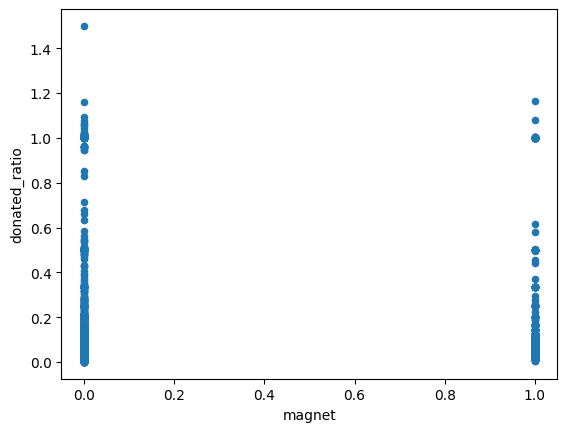

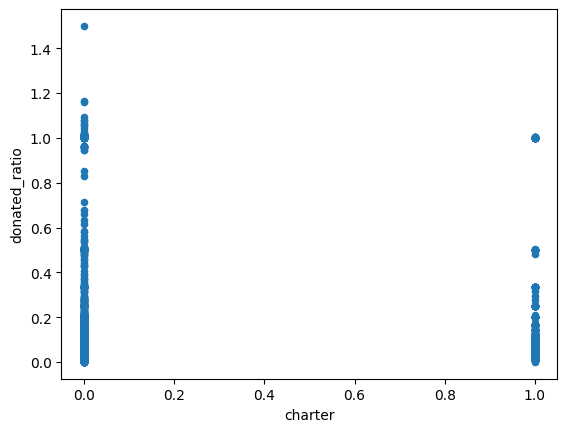

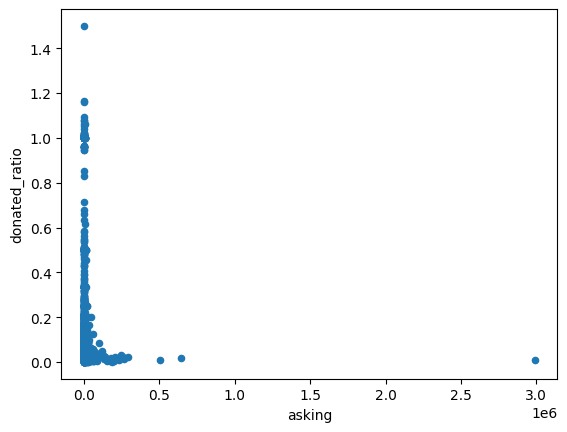

In [132]:
s = "SELECT p.projectid_str AS id, \
SUM(d.donation_to_project)  / SUM(p.total_asking_price) AS donated_ratio,  \
SUM(r.item_quantity * r.item_unit_price) AS total_cost \
FROM data.donations AS d \
INNER JOIN data.projects AS p ON d.projectid_str = p.projectid_str \
INNER JOIN data.resources AS r ON p.projectid_str = r.projectid_str \
GROUP BY p.projectid_str \
HAVING SUM(r.item_quantity * r.item_unit_price) IS NOT NULL AND  SUM(r.item_quantity * r.item_unit_price)  < 2713255.65 \
ORDER BY SUM(r.item_quantity * r.item_unit_price) \
"
# q(s)
# pd.read_sql(s, db_engine).plot.scatter(x='total_cost', y='donated_ratio')
s = "SELECT p.projectid_str AS id, \
SUM(d.donation_to_project)  / SUM(p.total_asking_price) AS donated_ratio,  \
SUM(p.total_asking_price) AS asking, \
BOOL_OR(p.school_charter) AS Charter, \
BOOL_OR(p.school_magnet) AS Magnet \
FROM data.donations AS d \
INNER JOIN data.projects AS p ON d.projectid_str = p.projectid_str \
GROUP BY p.projectid_str \
"

df = pd.read_sql(s, db_engine)
df['magnet'] = df['magnet'].astype(int)
df.plot.scatter(x='magnet', y='donated_ratio')
df['charter'] = df['charter'].astype(int)
df.plot.scatter(x='charter', y='donated_ratio')
df.plot.scatter(x='asking', y='donated_ratio')
df.loc[df['donated_ratio'] >= 1.0, 'met'] = 1
df.loc[df['donated_ratio'] < 1.0, 'met'] = 0
display(df)


print('Average ratio for magnet schools', df.loc[df['magnet'] == 1, 'donated_ratio'].mean())
print('Average ratio for non-magnet schools', df.loc[df['magnet'] == 0, 'donated_ratio'].mean())
print('Average ratio for charter schools', df.loc[df['charter'] == 1, 'donated_ratio'].mean())
print('Average ratio for non-charter schools', df.loc[df['charter'] == 0, 'donated_ratio'].mean())
print('Interestingly enough, non-magnet and non-charter schools have higher donation ratio')

print('Average asking price for projects that met full asking price in donations', df.loc[df['donated_ratio'] >= 1, 'asking'].mean())
print('Average asking price for projects that did NOT met full asking price in donations', df.loc[df['donated_ratio'] < 1, 'asking'].mean())
print('# of projects that met full asking price in donations', df.loc[df['donated_ratio'] >= 1, 'asking'].count())
print('# of projects that did NOT meet full asking price in donations', df.loc[df['donated_ratio'] < 1, 'asking'].count())


print('We can see from here on that the most important feature is probably the asking price. There is a significant \
difference between average asking prices of projects that met full asking price versus that did not.')


# QUESTION 2

For this question, you'll develop a model to help DonorsChoose **identify 10% of projects with the highest risk of failing to meet their funding goal** for their digital content expert review and provide suggestions. In order to intervene early in the process, DonorsChoose wants to identify these projects to help **immediately upon being posted** to the site.

Build and evaluate the performance of several machine learning models for this task. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Feel free to use any python packages available (such as sklearn) for this.

In [134]:
from sklearn.model_selection import train_test_split
dfx = df[['asking', 'charter', 'magnet', 'donated_ratio']].copy()
display(dfx)
y = dfx.pop('donated_ratio')
X = dfx
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(type(X_train))

,asking,charter,magnet,donated_ratio
0,1440.60,0,0,0.166667
1,712.94,0,0,1.000000
2,2003.36,0,0,0.125000
3,537.31,0,0,1.000000
4,3035.70,0,0,0.111111
...,...,...,...,...
12837,1153.85,0,0,0.200000
12838,332.00,0,0,1.000000
12839,135.68,0,0,1.000000
12840,1330.00,0,0,0.100000


<class 'pandas.core.frame.DataFrame'>


In [139]:
from sklearn.linear_model import LinearRegression
linearModel = LinearRegression()

linearModel.fit(X_train, y_train)
print(linearModel.score(X_test, y_test))

X_train_1 = X_train[['asking']].copy()
X_test_1 = X_test[['asking']].copy()

linearModel.fit(X_train_1, y_train)
print(linearModel.score(X_test_1, y_test))

0.015928966177293225
0.007862692749582845


So, here we can see that using magnet and charter features definitely help us make better prediction. We get a R1 score of 0.016 with the linear model.


In [142]:
from sklearn.svm import SVR
svmModel = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svmModel.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [143]:
svmModel.score(X_test, y_test)

0.14751042977509599

# QUESTION 3

Briefly discuss (in at most 1-2 paragraphs) the results of your analysis above: Which model would you select to deploy and why? Are there future analysis or improvements you would suggest? Are there other data sources you would ideally like to be able to incorporate into your models?

Since this is more like an ontroductory assignment, I decided to only use the most important features. For the output variable, I just used the ratio of total donations to the asking price so this ended up being a regression task. I used asking price, charter, magnet features to make my predictions. I tried linear and a SVM model. For the SVM model, I used a rbf kernel to extract non linear features. Unsurpisingly, the SVM model does much better than the liner model. This could be due to the fact the output variable has a non linear relationship with the features.

I could have also approached this as a binary classification task by having the boolean output variable indicating whether the full asking price was met through donations or not. I could try this approach for future assignments. I could also try other non linear kernels and using more features.

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Provide a link to your copy of the notebook when you submit the assignment in canvas.

Thank you and we're looking forward to a great semester in 10718!